In [1]:
import time
import random
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from timeit import default_timer as timer

# Dopasowanie wzorca do tekstu

## Algorytm naiwny

In [2]:
def naive_match(text, pattern):
    n = len(text)
    m = len(pattern)
    matches = []
    
    for i in range(n-m+1):
        if text[i:i+m] == pattern:
            matches.append(i)
    
    return matches

In [3]:
naive_match("abcdaabbaaad", "aa")

[4, 8, 9]

## Algorytm automatu skończonego

In [4]:
def transition_table(pattern):
    result = [{} for _ in range(len(pattern)+1)]
    alphabet = set(pattern)
    
    for q in range(len(pattern)+1):
        for letter in alphabet:
            k = min(len(pattern)+1, q+2)
            while True:
                k -= 1
                if k == 0 or pattern[:k] == (pattern[:q] + letter)[-k:]:
                    break
            result[q][letter] = k

    return result

In [5]:
delta = transition_table("aba")
for d in delta:
    print(d)

{'b': 0, 'a': 1}
{'b': 2, 'a': 1}
{'b': 0, 'a': 3}
{'b': 2, 'a': 1}


In [6]:
def finite_aut_match(text, delta):
    state = 0
    match_table = []

    for i in range(len(text)):
        state = delta[state].get(text[i], 0)
    
        if state == len(delta)-1:
            match_table.append(i-len(delta)+2)
    
    return match_table

In [7]:
finite_aut_match("algtxtabsabalaabalt", delta)

[9, 14]

## Algorytm KMP (Knutha-Morrisa-Pratta)

In [8]:
def get_longest_prefix(str_):
    longest = [0 for _ in range(len(str_))]
    j = 0
    for q in range(1, len(str_)):
        while j > 0 and str_[j] != str_[q]:
            j = longest[j-1]
        if str_[j] == str_[q]:
            j += 1
        longest[q] = j
    return longest

In [9]:
longest_prefix = get_longest_prefix("abaababaabaa")
longest_prefix

[0, 0, 1, 1, 2, 3, 2, 3, 4, 5, 6, 4]

In [10]:
def kmp_match(text, pattern, longest_prefix):
    n = len(text)
    m = len(pattern)
    i = 0
    j = 0 
    result = [] 

    while i < n:
        if text[i] == pattern[j]:
            i += 1
            j += 1
            if j == m:
                result.append(i-m)
                j = longest_prefix[j-1]
        else:
            if j > 0:
                j = longest_prefix[j-1]
            else:
                i += 1

    return result

In [11]:
longest_prefix = get_longest_prefix("aba")
kmp_match("algtxtabsabalaabalt", "aba", longest_prefix)

[9, 14]

---

## Testy czasowe

In [12]:
def test_naive_match(text, pattern):
    start = timer()
    naive_match(text, pattern)
    end = timer()
    
    return end-start

In [13]:
def test_transition_table(pattern):
    start = timer()
    transition_table(pattern)
    end = timer()
    
    return end-start

In [14]:
def test_finite_aut_match(text, pattern):
    delta = transition_table(pattern)
    start = timer()
    finite_aut_match(text, delta)
    end = timer()
    
    return end-start

In [15]:
def test_get_longest_prefix(str_):
    start = timer()
    get_longest_prefix(str_)
    end = timer()
    
    return end-start

In [16]:
def test_kmp_match(text, pattern):
    longest_prefix = get_longest_prefix(pattern)
    start = timer()
    kmp_match(text, pattern, longest_prefix)
    end = timer()
    
    return end-start

In [17]:
def time_test(text="", pattern="", random_text=False, rand_text_len=0, rand_pattern_len=0):
    if random_text:
        alphabet = list(string.ascii_lowercase)
        text = "".join(random.choices(alphabet, k=rand_text_len))
        pattern = "".join(random.choices(alphabet, k=rand_pattern_len))
    
    t_naive_pre = 0
    t_naive = test_naive_match(text, pattern)
    print(f"Algorytm naiwny wyszukiwanie: {t_naive} [s]")
    
    t_aut_pre = test_transition_table(pattern)
    delta = transition_table(pattern)
    t_aut = test_finite_aut_match(text, pattern)
    print(f"Preprocessing automatu: {t_aut_pre} [s]")
    print(f"Automat skończony wyszukiwanie: {t_aut} [s]")
    
    t_kmp_pre = test_get_longest_prefix(pattern)
    longest_prefix = get_longest_prefix(pattern)
    t_kmp = test_kmp_match(text, pattern)
    print(f"Preprocessing KMP: {t_kmp_pre} [s]")
    print(f"Algorytm KMP wyszukiwanie: {t_kmp} [s]")

    names = ["Naiwny", "Automat skończony", "KMP"]
    times_pre = [t_naive_pre, t_aut_pre, t_kmp_pre]
    times_alg = [t_naive, t_aut, t_kmp]

    fig, ax = plt.subplots()
    ax.bar(names, times_pre)
    ax.bar(names, times_alg, bottom = times_pre) 

## Losowe testy

Algorytm naiwny wyszukiwanie: 0.014445500000000777 [s]
Preprocessing automatu: 0.04848540000000057 [s]
Automat skończony wyszukiwanie: 0.019645099999998195 [s]
Preprocessing KMP: 2.1199999999055308e-05 [s]
Algorytm KMP wyszukiwanie: 0.016958200000001256 [s]


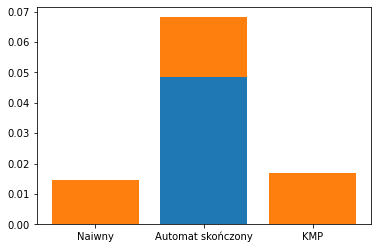

In [18]:
time_test(random_text=True, rand_text_len=100000, rand_pattern_len=100)

Algorytm naiwny wyszukiwanie: 4.199999999343618e-06 [s]
Preprocessing automatu: 1.8699999998261774e-05 [s]
Automat skończony wyszukiwanie: 4.499999999296733e-06 [s]
Preprocessing KMP: 4.000000000559112e-06 [s]
Algorytm KMP wyszukiwanie: 5.000000001587068e-06 [s]


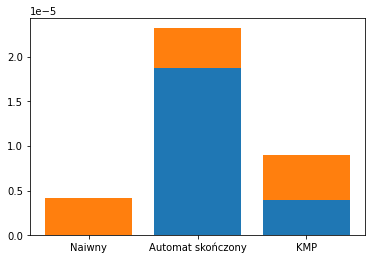

In [19]:
time_test(text="abcdabcadabcd", pattern="abc")

---

## Testy algorytmów na fragmencie epopei "Pan Tadeusz"

In [20]:
def find_in_file(file, pattern):
    with open(file, encoding="utf-8") as f:
        text = f.read()
        
    print(f"Ilość wystąpień słowa '{pattern}':")
    result = naive_match(text, pattern)
    print(f"- Algorytm naiwny: {len(result)}")
    
    delta = transition_table(pattern)
    result = finite_aut_match(text, delta)
    print(f"- Automat skończony: {len(result)}")
    
    longest_prefix = get_longest_prefix(pattern)
    result = kmp_match(text, pattern, longest_prefix)
    print(f"- Algorytm KMP: {len(result)}")

In [21]:
find_in_file("pan-tadeusz.txt", "pan")

Ilość wystąpień słowa 'pan':
- Algorytm naiwny: 401
- Automat skończony: 401
- Algorytm KMP: 401


In [22]:
find_in_file("pan-tadeusz.txt", "pani")

Ilość wystąpień słowa 'pani':
- Algorytm naiwny: 100
- Automat skończony: 100
- Algorytm KMP: 100


---

## Testy czasowe na fragmencie epopei "Pan Tadeusz"

In [23]:
def time_test_with_table(file, pattern):
    with open(file, encoding="utf-8") as f:
        text = f.read()
        
    t_naive_list = []
    t_aut_pre_list = []
    t_aut_list = []
    t_kmp_pre_list = []
    t_kmp_list = []
    t_aut_tot = []
    t_kmp_tot = []
    num_tests = 30

    for _ in range(num_tests):
        t_naive_pre = 0
        t_naive = test_naive_match(text, pattern)
        t_naive_list.append(t_naive*1000)

        t_aut_pre = test_transition_table(pattern)
        delta = transition_table(pattern)
        t_aut = test_finite_aut_match(text, pattern)
        t_aut_pre_list.append(t_aut_pre*1000)
        t_aut_list.append(t_aut*1000)
        t_aut_tot.append(t_aut_pre*1000+t_aut*1000)

        t_kmp_pre = test_get_longest_prefix(pattern)
        longest_prefix = get_longest_prefix(pattern)
        t_kmp = test_kmp_match(text, pattern)
        t_kmp_pre_list.append(t_kmp_pre*1000)
        t_kmp_list.append(t_kmp*1000)
        t_kmp_tot.append(t_kmp_pre*1000+t_kmp*1000)

    df = pd.DataFrame({
        "t_naive": t_naive_list,
        "t_aut_pre": t_aut_pre_list,
        "t_aut": t_aut_list,
        "t_aut_tot": t_aut_tot,
        "t_kmp_pre": t_kmp_pre_list,
        "t_kmp": t_kmp_list,
        "t_kmp_tot": t_kmp_tot})
    tot_df = df[["t_naive", "t_aut_tot", "t_kmp_tot"]]
    
    max_time = tot_df.max().max()
    min_time = tot_df.min().min()
    mean_time = tot_df.mean().mean()

    print(f"Maksymalny czas wyszukiwania: {max_time} [ms]")
    print(f"Minimalny czas wyszukiwania: {min_time} [ms]")
    print(f"Średni czas wyszukiwania: {mean_time} [ms]")
    
    df.index = np.arange(1, len(df) + 1)
    pd.set_option("display.width", 1000)
    display(df.style.set_properties(**{"text-align": "center"}).set_caption(f"Czasy wyszukiwania słowa '{pattern}' w '{file}'"))
    
    times_df = df[["t_naive", "t_aut_pre", "t_aut", "t_kmp_pre", "t_kmp"]]
    times_tot_df = df[["t_naive", "t_aut_tot", "t_kmp_tot"]]

    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    
    times_df.plot(ax=axs[0], kind="line")
    axs[0].legend(["Naiwny", "Automat preprocessing", "Automat wyszukiwanie",
                    "KMP preprocessing", "KMP wyszukiwanie"])
    axs[0].set_xlabel("Numer testu")
    axs[0].set_ylabel("Czas [ms]")
    axs[0].set_title("Pełna seria czasów")

    tot_df.plot(ax=axs[1], kind="line")
    axs[1].set_ylabel("Czas [ms]")
    axs[1].set_title("Czasy działania algorytmów wraz z preprocessingiem")
    axs[1].legend(["Naiwny", "Automat skończony wyszukiwanie i preproc.", "KMP wyszukiwanie i preproc."])
    axs[1].set_xlabel("Numer testu")
    
    plt.tight_layout()
    plt.show()

Maksymalny czas wyszukiwania: 112.0983999999936 [ms]
Minimalny czas wyszukiwania: 65.51270000000642 [ms]
Średni czas wyszukiwania: 76.14962555555589 [ms]


,t_naive,t_aut_pre,t_aut,t_aut_tot,t_kmp_pre,t_kmp,t_kmp_tot
1,71.696400,0.034500,88.313300,88.347800,0.007000,66.332900,66.339900
2,69.055800,0.035100,86.320700,86.355800,0.005000,65.952700,65.957700
3,68.939300,0.038300,87.618500,87.656800,0.005600,66.355200,66.360800
4,67.352700,0.036300,86.284000,86.320300,0.006700,65.725700,65.732400
5,69.621700,0.037600,112.060800,112.098400,0.007200,83.879500,83.886700
6,86.045100,0.037600,95.241800,95.279400,0.007900,75.666000,75.673900
7,72.522300,0.039400,86.944400,86.983800,0.007400,67.573500,67.580900
8,71.379200,0.039900,90.132100,90.172000,0.007100,68.439400,68.446500
9,72.528300,0.039700,89.755300,89.795000,0.009200,95.206900,95.216100
10,72.680600,0.038200,90.222700,90.260900,0.007000,71.169400,71.176400


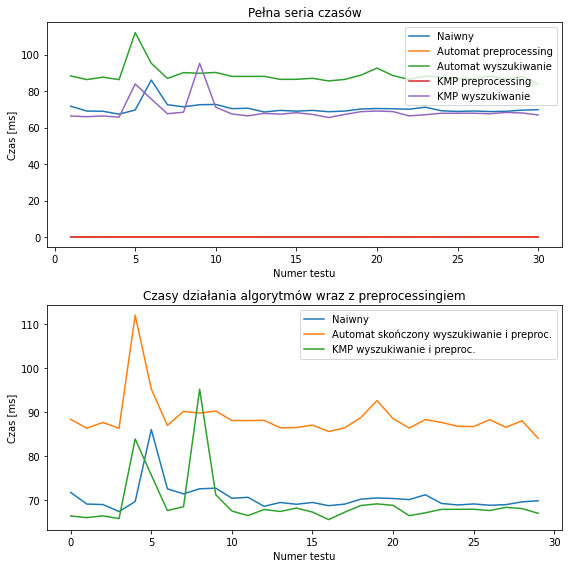

In [24]:
time_test_with_table("pan-tadeusz.txt", "pani")

Maksymalny czas wyszukiwania: 91.46110000000363 [ms]
Minimalny czas wyszukiwania: 64.98349999999675 [ms]
Średni czas wyszukiwania: 75.07953555555618 [ms]


,t_naive,t_aut_pre,t_aut,t_aut_tot,t_kmp_pre,t_kmp,t_kmp_tot
1,71.617100,0.027200,87.306000,87.333200,0.005700,67.090300,67.096000
2,70.409500,0.023800,89.437400,89.461200,0.005300,66.911700,66.917000
3,69.658200,0.025700,86.430600,86.456300,0.004900,66.323200,66.328100
4,70.530400,0.023300,87.220900,87.244200,0.004600,66.400400,66.405000
5,71.752000,0.028500,88.044100,88.072600,0.006200,67.109600,67.115800
6,68.906200,0.023800,88.850100,88.873900,0.006600,66.431200,66.437800
7,68.830600,0.024800,87.272900,87.297700,0.005800,67.264700,67.270500
8,69.025900,0.025700,86.550800,86.576500,0.004700,67.210500,67.215200
9,68.963300,0.023100,86.971300,86.994400,0.005300,67.950300,67.955600
10,69.105100,0.025500,86.770000,86.795500,0.009200,67.127500,67.136700


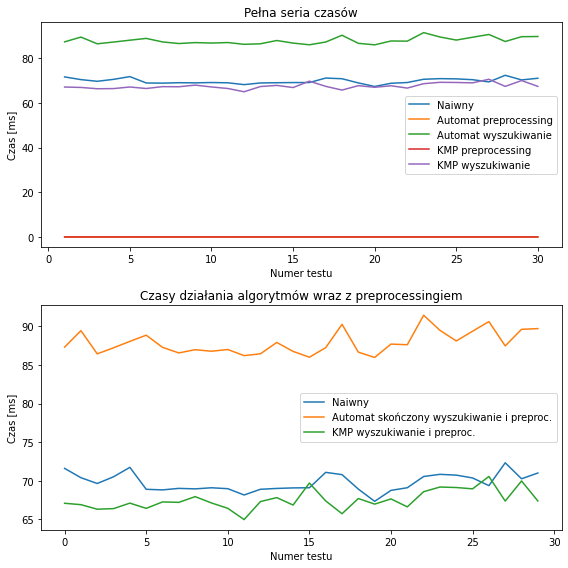

In [25]:
time_test_with_table("pan-tadeusz.txt", "pan")

---

## Tekst i wzorzec, dla którego czas działania alg. naiwnego jest 5 -krotnie krótszy

In [26]:
def time_test(text, pattern):
    
    t_naive_list = []
    t_aut_pre_list = []
    t_aut_list = []
    t_kmp_pre_list = []
    t_kmp_list = []
    t_aut_tot = []
    t_kmp_tot = []
    num_tests = 5

    for _ in range(num_tests):
        t_naive_pre = 0
        t_naive = test_naive_match(text, pattern)
        t_naive_list.append(t_naive)

        t_aut_pre = test_transition_table(pattern)
        delta = transition_table(pattern)
        t_aut = test_finite_aut_match(text, pattern)
        t_aut_pre_list.append(t_aut_pre)
        t_aut_list.append(t_aut)
        t_aut_tot.append(t_aut_pre+t_aut)

        t_kmp_pre = test_get_longest_prefix(pattern)
        longest_prefix = get_longest_prefix(pattern)
        t_kmp = test_kmp_match(text, pattern)
        t_kmp_pre_list.append(t_kmp_pre)
        t_kmp_list.append(t_kmp)
        t_kmp_tot.append(t_kmp_pre+t_kmp)

    df = pd.DataFrame({
        "t_naive": t_naive_list,
        "t_aut_pre": t_aut_pre_list,
        "t_aut": t_aut_list,
        "t_aut_tot": t_aut_tot,
        "t_kmp_pre": t_kmp_pre_list,
        "t_kmp": t_kmp_list,
        "t_kmp_tot": t_kmp_tot})
    
    times_search_df = df[["t_naive", "t_aut", "t_kmp"]]
    
    times_search_df.index = np.arange(1, len(df) + 1)
    pd.set_option("display.width", 1000)
    display(times_search_df.style.set_properties(**{"text-align": "center"}))

    times_search_df.plot(kind="line")
    plt.ylabel("Czas [s]")
    plt.title("Czasy działania algorytmów uwzględniające tylko dopasowanie")
    plt.legend(["Naiwny", "Automat skończony dopasowanie", "KMP dopasowanie"])
    plt.xlabel("Numer testu")
    
    plt.tight_layout()
    plt.show()

,t_naive,t_aut,t_kmp
1,6.715493,0.385168,0.346582
2,6.727063,0.393151,0.338586
3,6.634764,0.393265,0.355940
4,6.633760,0.405930,0.339788
5,6.986604,0.388658,0.329903


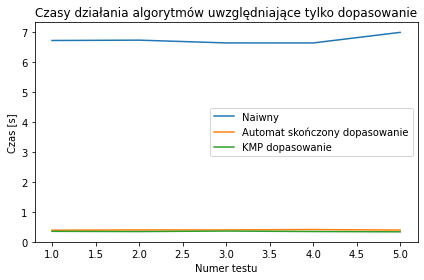

In [27]:
time_test("a"*1000000+"b"*100, "a"*100000)

---

## Wnioski

Wybór algorytmu do wyszukiwania wzorca w tekście powinien zależeć od konkretnych potrzeb i parametrów zadania. Podczas eksperymentów okazało się, że najkrótszym czasem działania dla krótkich tekstów oraz wzorców charakteryzuje się algorytm naiwny oraz KMP. Algorytm naiwny pomimo kwadratowej złożoności czasowej w stosunkowo krótkim czasie potrafi wyszukać krótkie wzorce w tekście. Zauważalne jest to bowiem we fragmentach 'Pana Tadeusza', dla którego wyszukiwane są krótkie wzorce. Czasowo jest on podobny do algorytmu KMP, który posiada liniową złożoność czasową. Jednakże różnice zauważalne są na etapie zwielokrotnienia długości tekstu i wzorca. Jedne z największych różnic czasowych pomiędzy algorytmem naiwnym a pozostałymi dwoma występują przykładowo dla tekstu: "a"*1000000+"b"*100 oraz wzorca "a"*100000. W tej sytuacji algorytm naiwny działa kilkukrotnie wolniej od pozostałych.
Jeżeli chodzi o automat skończony, to posiada on algorytm preprocessingu o większym czasie działania niż algorytm KMP. Dla krótkich tekstów działa on najwolniej, jednakże dla dłuższych tekstów i wzorców posiada on wielokrotnie krótszy czas działania niż algorytm naiwny.
W związku z powyższym, uniwersalnym algorytmem do wyszukiwania wzorców w tekście jest algorytm KMP.